# CentraleSupelec - Natural language processing
# Practical session n°7

## Natural Language Inferencing (NLI): 

(NLI) is a classical NLP (Natural Language Processing) problem that involves taking two sentences (the premise and the hypothesis ), and deciding how they are related (if the premise *entails* the hypothesis, *contradicts* it, or *neither*).

Ex: 


| Premise | Label | Hypothesis |
| --- | --- | --- |
| A man inspects the uniform of a figure in some East Asian country. | contradiction | The man is sleeping. |
| An older and younger man smiling. | neutral | Two men are smiling and laughing at the cats playing on the floor. |
| A soccer game with multiple males playing. | entailment | Some men are playing a sport. |

### Stanford NLI (SNLI) corpus

In this labwork, I propose to use the Stanford NLI (SNLI) corpus ( https://nlp.stanford.edu/projects/snli/ ), available in the *Datasets* library by Huggingface.

    from datasets import load_dataset
    snli = load_dataset("snli")
    #Removing sentence pairs with no label (-1)
    snli = snli.filter(lambda example: example['label'] != -1) 

## Subject

You are asked to provide an operational Jupyter notebook that performs the task of NLI. For that, you need to tackle the following aspects of the problem:

1. Loading and preprocessing the data
2. Designing a PyTorch model that, given two sentences, decides how they are related (*entails*, *contradicts* or *neither*.)
3. Training and evaluating the model using appropriate metrics
4. (Optional) Allowing to play with the model (forward user sentences and visualize the prediction easily)
5. (Optional) Providing visual insight about the model (i.e. visualizing the attention if your model is using attention)

Although it is not mandatory, I suggest that you use a transformer model to perform the task. For that, you can use the *Transformer* library by Huggingface.

## Evaluation

The evaluation will be based on several criteria:

- Clarity and readability of the notebook. The notebook is the report of you project. Make it easy and pleasant to read.
- Justification of implementation choices (i.e. the network, the cost funtion, the optimizer, ...)
- Quality of the code. The various deeplearning and NLP labworks provide many example of good practices for designing experiments with neural networks. Use them as inspirational examples!

## Additional recommendations

- You are not seeking to publish a research paper! I'm not expecting state-of-the-art results! The idea of this labwork is to assess that you have integrated the skills necessary to handle textual data using deep neural network techniques.

- This labwork will be evaluated but we are still here to help you! Don't hesitate to request our help if you are stuck.

- If you intend to use BERT based models, let me give you an advice. The bert-base-* models available in *Transformers* need more than 12Go to be fine-tuned on GPU. To avoid memory issues, you can use several solutions: 

    - Use a lighter BERT based model such as DistilBERT, ALBERT, ...
    - Train a classification model on top of BERT, whithout fine-tuning it (i.e. freezing BERT weights)

## Huggingface documentations

In case you want to use the huggingface *Datasets* and *Transformer* libraries (which I advice), here are some useful documentation pages:

- Dataset quick tour

    https://huggingface.co/docs/datasets/quicktour.html
    
- Documentation on data preprocessing for transformers

    https://huggingface.co/transformers/preprocessing.html
    
- Transformer Quick tour (with distilbert example for classification).

    https://huggingface.co/transformers/quicktour.html
    


In [1]:
from transformers import AutoTokenizer, AutoModel
from transformers import logging as lg
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from utils import train, test, ModelCheckpoint, generate_unique_logpath
from models import *
import re
from data import *
import yaml
import os
import numpy as np
lg.set_verbosity_error()
label = ["entailment","neutral", "contradiction"]
config = yaml.safe_load(open("config.yaml", "r"))

/usr/users/sdi-labworks-2023-2024/sdi-labworks-2023-2024_19/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
use_cuda = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler() # we create this object to be able to run at fp16 for training
batch_size = config["data"]["batch_size"] # we get the different config from a yaml file
num_worker = config["data"]["num_worker"]
max_length = config["data"]["max_length"]
base_model = config["model"]["base"]
model_type = config["model"]["type"]
EPOCH = config["train"]["epoch"]
LR = config["optimizer"]["lr"]

In [4]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
bert = AutoModel.from_pretrained(base_model, output_attentions=True)

In [5]:
train_dataloader, valid_dataloader = get_train_val_dataloader(tokenizer, batch_size, max_length, num_worker, use_cuda)

In [6]:
if model_type == "distill":
    model = BertNLIModelDistill(bert)
else:
    model = BertNLIModel(bert) # initialization of the model with the bert model passed as parameter
model.to(device)
f_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps=1e-6)

In [7]:
logdir = generate_unique_logpath("logs", model_type)
if not os.path.isdir("logs"):
    os.makedirs("logs")

if not os.path.isdir(logdir):
    os.makedirs(logdir)

model_checkpoint = ModelCheckpoint(
    model, str(logdir + "/best_model.pt"), min_is_best=True
)

In [8]:
for i in range(EPOCH):
    train_loss, train_acc = train(train_dataloader, model, f_loss, optimizer, device, scaler,model_type)
    valid_loss, valid_acc = test(valid_dataloader, model, f_loss, device,model_type)
    model_checkpoint.update(valid_loss)

Test_CE : 0.26, accuracy: 90.74 %: 100%|██████████| 154/154 [00:06<00:00, 22.71it/s]


In [9]:
model.load_state_dict(torch.load(logdir + "/best_model.pt", map_location=device))
model.eval()


BertNLIModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [10]:
sentence_1 = "I love F1"
sentence_2 = "I hate F1"
data = tokenizer(sentence_1, sentence_2, padding="max_length", truncation=True, max_length=max_length)

In [13]:
if model_type == "bert":
    x = (torch.tensor(data["input_ids"],dtype=torch.int32, device=device).unsqueeze(0), torch.tensor(data["attention_mask"], dtype=torch.int32, device=device).unsqueeze(0),torch.tensor(data["token_type_ids"],dtype=torch.int32, device=device).unsqueeze(0))
else:
    x = (torch.tensor(data["input_ids"],dtype=torch.int32, device=device).unsqueeze(0), torch.tensor(data["attention_mask"], dtype=torch.int32, device=device).unsqueeze(0))

In [29]:
with torch.no_grad():
    if model_type == "bert":
        r, attention = model(input_ids=x[0], attention_mask=x[1], token_type_ids=x[2])
    else:
        r, attention = model(input_ids=x[0], attention_mask=x[1])
print(f"prediction: {label[np.argmax(r[0].cpu().numpy())]} with {np.max(torch.softmax(r, dim=1)[0].cpu().numpy()*100):.2f} % of confidence")

prediction: contradiction with 99.86 % of confidence


In [15]:
head_index = 0
attention_weights = attention[0][head_index].detach().cpu().numpy()

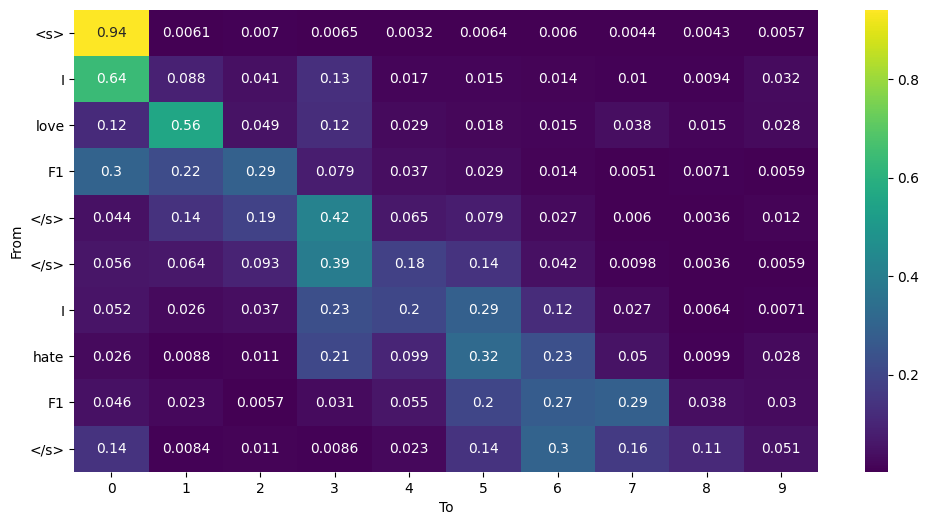

In [25]:
if model_type == "bert":
    size = len(sentence_1.split()) + len(sentence_2.split()) + 3
    result = tokenizer.decode(data["input_ids"]).split()[0:size]
else:
    string = tokenizer.decode(data["input_ids"])
    pattern = re.compile(r'(<\/?s>|<pad>|[\w\d]+)')
    result = pattern.findall(string)
    result = [s.strip() for s in result if s.strip() != '' and s.strip() != "<pad>"]
    size = len(result)
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.heatmap(attention_weights[0:size, 0:size], cmap='viridis', annot=True, ax=ax,yticklabels=False)
ax.set_yticks([x + 0.5 for x in range(0, size)])
ax.set_yticklabels(result, rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.show()

In [26]:
test_dataloader = get_test_dataloader(tokenizer,batch_size,max_length,num_worker,use_cuda)

Map (num_proc=8): 100%|██████████| 9824/9824 [00:04<00:00, 1999.04 examples/s]


In [27]:
test_loss, test_acc = test(test_dataloader, model, f_loss, device, model_type)

Test_CE : 0.26, accuracy: 90.43 %: 100%|██████████| 154/154 [00:06<00:00, 22.95it/s]


In [28]:
print(f"test loss: {test_loss:.2f}")
print(f"test acc: {(test_acc*100):.2f} %")

test loss: 0.26
test acc: 90.43 %
